In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)

In [2]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df    

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df.drop(columns="total_CPM", inplace=True)
    
    return merged_df

In [30]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split("source_transcript=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get CHM gene_ids
        df["CHM_gene_id"] = df["other"].str.split("gene_id=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["CHM_transcript_id"] = df["other"].str.split("transcript_id=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get transcript names
        df["transcript_name"] = df["other"].str.split("source_transcript_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get start codon
        df["start_codon"] = df["other"].str.split("adj_start=", expand=True)[1].str.split(";", expand=True)[0]
        
        ## Get stop codon
        df["stop_codon"] = df["other"].str.split("adj_stop=", expand=True)[1].str.split(";", expand=True)[0]        

        ## Only keep relevant
        df = df[["chr", "start", "end", "strand", "type", "gene_id", "transcript_id", "CHM_gene_id",
                 "CHM_transcript_id", "transcript_name", "gene_name", "start_codon", "stop_codon"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]


        ## Get CHM transcript ids
        #df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        #df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [6]:
'''
function name: merge_annotations

purpose: Merge useful/relevant information from both annotations while removing repeated and irrelevant information

input: Two different GTF annotations

output: One GTF annotation containing all the relevant information
'''

def merge_annotations(ref_gtf, bambu_gtf):
    
    ## Merge the two annotations
    names_ref_gtf = ref_gtf[["transcript_id", "gene_id", "gene_name", "transcript_name"]].copy()
    merged_gtf = pd.merge(bambu_gtf, names_ref_gtf, on=['gene_id', 'transcript_id'], how='left')
    merged_gtf.drop_duplicates(inplace=True)

    ## Label novel transcripts
    merged_gtf.loc[merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
    merged_gtf.loc[~merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

    ## Label novel genes
    merged_gtf.loc[merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
    merged_gtf.loc[~merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

    ## Create temporary variable only containing novel transcripts
    temp = merged_gtf.loc[merged_gtf["is_novel_transcript"] == True]

    ## Annotate novel transcripts
    merged_tmp = pd.merge(temp, ref_gtf[["gene_id", "gene_name"]], on=['gene_id'], how='left')
    merged_tmp.drop_duplicates(inplace=True)
    merged_tmp["gene_name"] = merged_tmp["gene_name_y"]
    merged_tmp.drop(columns=["source", "gene_name_y", "gene_name_x"], inplace=True)

    ## Return novel transcripts to original annotation
    merged_final = pd.merge(merged_gtf, merged_tmp, on=['chr', 'type', 'start', 'end', 'strand', 'transcript_id',
                    'transcript_name', 'gene_id', 'is_novel_transcript', 'is_novel_gene', 'exon_number'], how="left")

    ## Get gene names for novel transcripts of known genes
    merged_final.gene_name_x.fillna(merged_final.gene_name_y, inplace=True)
    merged_final["gene_name"] = merged_final["gene_name_x"]
    merged_final.drop(columns =["gene_name_x", "gene_name_y"], inplace=True)
    
    ## Get start and stop codons for known transcripts and exons of protein coding genes
    ref_gtf = ref_gtf[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "start_codon", "stop_codon"]]
    merged_final = pd.merge(merged_final, ref_gtf, on=["chr", "type", "start", "end", "strand", "transcript_id", "gene_id"], how="left")
    
    
    merged_final = merged_final[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "gene_name", 
                    "exon_number", "transcript_name", "start_codon", "stop_codon", "is_novel_gene", "is_novel_transcript"]]


    
    return merged_final 

In [7]:
'''
name: make_gene_and_transcript_converter

input: The CHM13 CAT/Liftoff gff annotation version 2.0

output: A dataframe with ["gene_id", "transcript_id", "gene_name", "transcript_name"] formatted in the same way as the 
bambu reference, so that we can properly assign gene and transcript names.

purpose: Creating a list that allows us to assign transcript and gene names to the bambu annotation based on the transcript
id and gene ID
'''


def make_gene_and_transcript_converter(gff):
    
    ## Change name of duplicate Ensembl IDs to CHM IDs
    gff.loc[gff["transcript_id"] == "N/A", "transcript_id"] = gff["CHM_transcript_id"]
    gff_transcripts = gff.loc[gff["type"] == "transcript"].copy()
    gff_transcripts = gff_transcripts[["transcript_id", "CHM_transcript_id"]].drop_duplicates()
    gff_transcripts = gff_transcripts[gff_transcripts['transcript_id'].duplicated() == True]
    dup_trans = gff_transcripts["transcript_id"].dropna().values.tolist()
    gff.loc[gff["transcript_id"].isin(dup_trans), "transcript_id"] = gff["transcript_id"] + "(" + gff["CHM_transcript_id"] + ")"

    ## Change name of duplicate gene ids to CHM ids
    gff.loc[gff["gene_id"] == "None", "gene_id"] = gff["CHM_gene_id"]
    gff_genes = gff.loc[gff["type"] == "transcript"].copy()
    gff_genes = gff_genes[["gene_id", "CHM_gene_id"]].drop_duplicates()
    gff_genes = gff_genes[gff_genes['gene_id'].duplicated() == True]
    dup_genes = gff_genes["gene_id"].dropna().values.tolist()
    gff.loc[gff["gene_id"].isin(dup_genes), "gene_id"] = gff["gene_id"] + "(" + gff["CHM_gene_id"] + ")"

    
    ## Fix gene names for MSTRG Genes
    gff_names = gff.loc[gff["type"] == "transcript"].copy()
    gff_names = gff_names[["gene_id", "gene_name"]].copy()
    gff_names.loc[gff_names["gene_name"].str.contains("MSTRG."), "gene_name"] = np.NaN
    gff_names.dropna(inplace=True)
    gff_names.drop_duplicates(inplace=True, subset=["gene_id"])
    gff.drop(columns="gene_name", inplace=True)
    gff = pd.merge(gff, gff_names, on="gene_id", how="left")
    gff = gff[["gene_id", "transcript_id", "gene_name", "transcript_name",
              "start", "end", "type", "start_codon", "stop_codon", "chr", "strand"]].copy()


    return gff

In [13]:
## Fix column names in counts matrix

grch38_counts = pd.read_csv("../../data/raw/merged_aged_stringent/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

grch38_counts = fix_column_names(grch38_counts, is_gene=False)

In [14]:
## Calculate total counts and fix gene id
grch38_counts["total_counts"] = grch38_counts[grch38_counts.columns[2:6].tolist()].sum(axis=1)

In [15]:
## Calculate CPM and drop count columns
grch38_counts = calculate_cpm(grch38_counts, is_gene=False)

grch38_counts = grch38_counts[grch38_counts.columns.drop(list(grch38_counts.filter(regex='counts')))]

In [16]:
## Find novel transcripts in both annotations
grch38_counts.loc[grch38_counts["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
grch38_counts.loc[~grch38_counts["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

## Find novel genes in both annotations
grch38_counts.loc[grch38_counts["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
grch38_counts.loc[~grch38_counts["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

In [17]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
grch38_novel_genes = grch38_counts.loc[grch38_counts["is_novel_gene"]].copy()
grch38_novel_transcripts = grch38_counts.loc[((grch38_counts["is_novel_transcript"]) & (~grch38_counts["is_novel_gene"]))].copy()

In [18]:
## See how many novel genes
print("We found", grch38_novel_genes.shape[0], "novel genes in GRCh38")

We found 207 novel genes in GRCh38


In [19]:
## Filter novel genes and transcripts, total CPM > 1
grch38_novel_genes = grch38_novel_genes[(grch38_novel_genes["total_CPM"]>1)]
grch38_novel_transcripts = grch38_novel_transcripts[(grch38_novel_transcripts["total_CPM"]>1)]

In [20]:
## Count number of novel genes and novel transcripts in each dataframe
print("We found", grch38_novel_genes.shape[0], "novel genes in GRCh38")
print("We found", grch38_novel_transcripts.shape[0], "novel transcripts of known genes in GRCh38")

We found 79 novel genes in GRCh38
We found 472 novel transcripts of known genes in GRCh38


In [23]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
grch38_ref = pd.read_csv("../../data/raw/merged_aged_stringent/bambu_discovery/extended_annotations.gtf",
                        header=None, delimiter="\t", low_memory=False, 
                        names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


grch38_ref = parse_df_columns(grch38_ref, is_ref=False)

In [24]:
## Only keep transcripts
grch38_ref = grch38_ref.loc[grch38_ref["type"] == "transcript"]

In [25]:
## Only keep expressed transcripts
grch38_novel_transcripts_expressed = grch38_ref.loc[grch38_ref["transcript_id"].isin(
                                                    grch38_novel_transcripts["transcript_id"])].copy()

In [26]:
## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../references/disease_relevant_gene_names.csv", 
                                     names=["gene_id", "gene_name"], header=0)
## Ad genes
ad_names = pd.read_csv("../../references/AD_genes.csv", sep="\t")
ad_names.dropna(inplace=True)
ad_names.drop_duplicates(inplace=True)

## Concatenate both
disease_relevant_genes = pd.concat([disease_relevant_genes, ad_names]).drop_duplicates()


In [28]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
orig_ref = pd.read_csv("../../references/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")


In [31]:
## Create good reference to convert gene names
orig_ref = orig_ref.loc[orig_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=False)

In [32]:
## Create list of novel transcripts in disease relevant genes
novel_relevant = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name"]], on=["gene_id", "gene_name"], how="inner")

In [33]:
## Only keep gene_ids that match, add gene names
novel_relevant = grch38_novel_transcripts_expressed.merge(novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [34]:
## Drop any duplicates
novel_relevant.drop_duplicates(inplace=True)

In [35]:
## See shape
novel_relevant.shape

(45, 10)

In [36]:
## Remove MT transcripts
novel_relevant = novel_relevant.loc[novel_relevant["chr"] != "MT"]

In [38]:
novel_relevant["gene_id"].value_counts()

ENSG00000114956    2
ENSG00000145920    2
ENSG00000196236    1
ENSG00000113851    1
ENSG00000163939    1
ENSG00000145217    1
ENSG00000185049    1
ENSG00000153113    1
ENSG00000112981    1
ENSG00000027847    1
ENSG00000168958    1
ENSG00000070501    1
ENSG00000147647    1
ENSG00000165092    1
ENSG00000165115    1
ENSG00000119414    1
ENSG00000102172    1
ENSG00000069535    1
ENSG00000160194    1
ENSG00000188641    1
ENSG00000132692    1
ENSG00000128928    1
ENSG00000285053    1
ENSG00000138336    1
ENSG00000134569    1
ENSG00000149489    1
ENSG00000010610    1
ENSG00000123297    1
ENSG00000102678    1
ENSG00000067225    1
ENSG00000143919    1
ENSG00000174990    1
ENSG00000065559    1
ENSG00000041353    1
ENSG00000197013    1
ENSG00000205155    1
ENSG00000172554    1
ENSG00000138030    1
ENSG00000155962    1
Name: gene_id, dtype: int64

In [31]:
## Only keep original ensembl ID
grch38_counts_ensembl_id = grch38_counts.copy()

In [32]:
## Merge with medically relevant genes on gene_id and get gene names
novel_relevant_counts = pd.merge(grch38_counts_ensembl_id, novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [33]:
## Drop any duplicates
novel_relevant_counts.drop_duplicates(inplace=True)

In [34]:
## See shape
novel_relevant_counts.shape

(449, 10)

In [35]:
## See number of novel transcript left
novel_relevant_counts.loc[novel_relevant_counts["is_novel_transcript"]==True].shape

(41, 10)

In [36]:
## Calculate relative transcript abundance
novel_relevant_relative_abundance = relative_transcript_abundance(novel_relevant_counts)

In [37]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_words = novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["is_novel_transcript"] == True][["gene_name", "relative_abundance_percent"]]

In [38]:
## Drop duplicates
novel_relevant_words = novel_relevant_words.drop_duplicates()

In [39]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_words = round(novel_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [40]:
## Create a dataframe to properly store the data
novel_relevant_word_df = pd.DataFrame()
novel_relevant_word_df['word_count'] = novel_relevant_words
novel_relevant_word_df["gene_name"] = novel_relevant_words.index

In [41]:
## Drop index
novel_relevant_word_df.reset_index(inplace=True, drop=True)

In [42]:
## Print genes with novel isoforms relevant to AD
ad_names = pd.read_csv("../../references/AD_genes.csv", sep="\t")
print(novel_relevant_word_df.loc[novel_relevant_word_df["gene_name"].isin(ad_names["gene_name"])])

Empty DataFrame
Columns: [word_count, gene_name]
Index: []


In [43]:
## Print relative abundance for a couple other genes
print(novel_relevant_word_df.loc[novel_relevant_word_df["gene_name"].isin(["MAOB", "SLC26A1"])])

    word_count gene_name
18         9.0      MAOB
31        90.0   SLC26A1


In [44]:
novel_relevant_word_df

,word_count,gene_name
0,74.0,ALDH1A1
1,16.0,B4GALT7
2,33.0,BCAN
3,70.0,CA5A
4,75.0,CAMKMT
5,18.0,CAST
6,61.0,CD4
7,34.0,CLIC2
8,24.0,CPLX2
9,12.0,CRBN


In [46]:
novel_relevant_word_df["gene_name"].to_list()

['ALDH1A1',
 'B4GALT7',
 'BCAN',
 'CA5A',
 'CAMKMT',
 'CAST',
 'CD4',
 'CLIC2',
 'CPLX2',
 'CRBN',
 'DGUOK',
 'DPYD',
 'DPYS',
 'FGF9',
 'IVD',
 'KHK',
 'KIF27',
 'LRP4',
 'MAOB',
 'MAP2K4',
 'MFF',
 'NDUFV3',
 'NELFA',
 'NME5',
 'PBRM1',
 'PKM',
 'POLB',
 'PPP6C',
 'PSENEN',
 'RAB27B',
 'ROM1',
 'SLC26A1',
 'SMS',
 'SNTG2',
 'TBCE',
 'TET1',
 'TSFM',
 'XPNPEP3',
 'ZNF429']

In [47]:
## Print number of disease relevant genes with high-confidence novel isoforms
novel_relevant_word_df["gene_name"].nunique()

39

In [48]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
word_list = ""

for i in range(len(novel_relevant_word_df)):
        
    for j in range(int(novel_relevant_word_df.iloc[i][0])):
        word_list = word_list + novel_relevant_word_df.iloc[i][1] + " "
        

In [108]:
## Generate wordcloud
word_cloud = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap="brg", prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=16000, height=20000).generate(word_list)

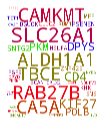

In [109]:
## Save the in-person poster version (higher DPI) 
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../../figures/uky_CS_summit/word_cloud_in-person.png', dpi=600, transparent=True, bbox_inches="tight")
plt.show()

###########################################################################################################################

In [53]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
orig_ref = pd.read_csv("../../references/Homo_sapiens.GRCh38.101.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])




In [54]:
## Create good reference to convert gene names
orig_ref = parse_df_columns(orig_ref, is_ref=False)
#orig_ref = orig_ref.loc[orig_ref["type"]=="gene"].copy()

In [55]:
orig_ref.loc[((orig_ref["gene_id"].str.contains("ENSG00000108379")) & (orig_ref["type"]=="transcript"))]

,chr,source,type,start,end,strand,gene_id,gene_name
2472981,17,ensembl_havana,transcript,46762506.0,46818692.0,-,ENSG00000108379,WNT3
2472996,17,havana,transcript,46773842.0,46833033.0,-,ENSG00000108379,WNT3
2473001,17,havana,transcript,46830595.0,46833058.0,-,ENSG00000108379,WNT3
2473005,17,havana,transcript,46831405.0,46833154.0,-,ENSG00000108379,WNT3


In [56]:
## Only keep gene_ids that match between both
grch38_counts_with_name = grch38_counts.merge(orig_ref[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [57]:
## Drop any duplicates
grch38_counts_with_name.drop_duplicates(inplace=True)

In [58]:
grch38_counts_with_name["gene_id"] = grch38_counts_with_name["gene_id"].str.split(".", expand=True)[0]

In [59]:
## Get the gene names in the counts matrix and only keep medically relevant genes
medically_relevant_counts = grch38_counts_with_name.merge(disease_relevant_genes[["gene_id", "gene_name"]], on=["gene_id", "gene_name"], how="inner")

In [60]:
## Delete duplicates
medically_relevant_counts.drop_duplicates(inplace=True)

In [61]:
## Remove all isoforms without CPM > 5 reads in every sample
medically_relevant_counts = medically_relevant_counts[(medically_relevant_counts["total_CPM"]>5)].copy()

In [62]:
## Only keep genes with more than one "highly expressed" isoforms
dup_gene_names = medically_relevant_counts.loc[medically_relevant_counts.duplicated(subset="gene_id")]

medically_relevant_counts_multiple_iso = medically_relevant_counts.loc[medically_relevant_counts["gene_id"].isin(dup_gene_names["gene_id"])].copy()

In [63]:
## How many medically relevant isoforms with more than one highly expressed isoforms in one gene
medically_relevant_counts_multiple_iso.shape

(2370, 10)

In [64]:
## How many highly expressed isoforms are there for each gene?
df_numbers = medically_relevant_counts_multiple_iso["gene_id"].value_counts()

In [65]:
## How many medically relevant genes have more than one highly expressed isoform?
medically_relevant_counts_multiple_iso["gene_id"].nunique()

914

In [66]:
## Display their names
medically_relevant_counts_multiple_iso["gene_name"].unique()

array(['BCAN', 'LRP4', 'ROM1', 'PKM', 'MAP2K4', 'ZNF429', 'PSENEN', 'KHK',
       'DGUOK', 'MFF', 'NDUFV3', 'CRBN', 'NELFA', 'CAST', 'CPLX2', 'POLB',
       'ALDH1A1', 'PPP6C', 'MT-TQ', 'MAOB', 'MT-TS1', 'SMS', 'CD74',
       'ERCC1', 'GABRA1', 'RB1CC1', 'RNASET2', 'GOPC', 'DCN', 'KIF22',
       'KCNAB2', 'REEP1', 'KEAP1', 'ASNS', 'ALDH3A2', 'MRPS34', 'SLC25A3',
       'CTSA', 'ACTN1', 'DLG3', 'MAP2', 'LAMP2', 'EPB41L1', 'SPG21',
       'GNPTG', 'GOLGA3', 'COMT', 'TECR', 'MIF', 'XBP1', 'SYNGR1', 'ACO2',
       'HSP90AA1', 'SUPT16H', 'APEX1', 'PABPN1', 'ARHGAP5', 'NFKBIA',
       'EEF1A2', 'WDR13', 'FMR1', 'PQBP1', 'HUWE1', 'ARHGEF7', 'USB1',
       'FDFT1', 'GDAP1', 'EIF3E', 'NEFM', 'PNPLA6', 'FCGRT', 'FKBP8',
       'PON2', 'CLIP2', 'AK1', 'SETX', 'VIM', 'SLC25A39', 'GIT1', 'WNT3',
       'GOSR2', 'DDX5', 'KAT2A', 'RANGRF', 'WFS1', 'LDHA', 'CRYAB',
       'PPFIBP1', 'TPI1', 'C12orf57', 'BCL6', 'NCK2', 'MPV17', 'RPS15',
       'GGCX', 'RPL22', 'MFN2', 'PRDM2', 'HMGCL', 'CTSD', 'EEF1B2'

In [67]:
## Display number of isoforms for key genes I am interested in
medically_relevant_counts_multiple_iso.loc[medically_relevant_counts_multiple_iso["gene_name"].isin(["MAPT", "APP", "SNCA", "PARK7", "PINK1"])]["gene_name"].value_counts()

SNCA     6
APP      4
MAPT     3
PINK1    2
PARK7    2
Name: gene_name, dtype: int64

In [68]:
## Display number of isoforms for key genes I am interested in
medically_relevant_counts_multiple_iso.loc[medically_relevant_counts_multiple_iso["gene_id"].isin(ad_names["gene_id"])]["gene_name"].value_counts()

CTSB     5
BIN1     4
CLU      4
APP      4
COX7C    3
WNT3     2
NCK2     2
SORT1    2
WDR12    2
ANK3     2
JAZF1    2
TNIP1    2
DOC2A    2
Name: gene_name, dtype: int64

In [69]:
## Display number of isoforms for key genes for all
medically_relevant_counts_multiple_iso["gene_name"].value_counts()

HNRNPA2B1     14
GNAS          12
CRYAB         10
DTNA          10
RPS24          8
NTRK2          8
SNAP25         8
BSCL2          7
ACTB           7
SNRPN          7
HSPB1          7
DST            6
FDPS           6
CSDE1          6
CHN1           6
KCNAB2         6
MAPK10         6
ABI1           6
SNCA           6
SPP1           6
SLC1A3         6
PKM            6
ANK2           6
MATR3          5
DCTN1          5
COX4I1         5
HSPA9          5
UQCRQ          5
DGUOK          5
CALM3          5
GRHPR          5
CTSB           5
KIF1B          5
NACA           5
HLA-A          5
IL6ST          5
ACADVL         5
CCND3          5
DDX5           5
FIP1L1         5
CALM2          5
PSIP1          5
KIF5A          5
MEG3           5
APP            4
KLC1           4
SYNE1          4
HNRNPK         4
CTNNB1         4
NRCAM          4
CD59           4
ALDOA          4
PC             4
LDHB           4
MFN2           4
RPS15          4
B2M            4
GRIN1          4
BCAN          

In [70]:
## How many highly expressed isoforms are there for each gene?
df_numbers = medically_relevant_counts_multiple_iso["gene_name"].value_counts()

In [71]:
medically_relevant_counts_multiple_iso['Number of Isoforms'] = medically_relevant_counts_multiple_iso['gene_id'].copy().map(medically_relevant_counts_multiple_iso['gene_id'].value_counts())

In [72]:
medically_relevant_counts_multiple_iso.drop_duplicates(inplace=True, subset="gene_id")

In [73]:
medically_relevant_counts_multiple_iso.head()

,transcript_id,gene_id,cshl_356_uky_CPM,cshl_1271_uky_CPM,cshl_1291_uky_CPM,cshl_1304_uky_CPM,total_CPM,is_novel_transcript,is_novel_gene,gene_name,Number of Isoforms
6,tx.49,ENSG00000132692,39.91,40.27,25.59,38.03,36.37,True,False,BCAN,4
38,ENST00000378623,ENSG00000134569,10.78,16.26,28.33,14.67,17.19,False,False,LRP4,2
43,tx.127,ENSG00000149489,7.40,11.41,8.66,8.27,9.01,True,False,ROM1,3
79,tx.221,ENSG00000067225,235.90,792.64,65.24,303.45,369.91,True,False,PKM,6
113,ENST00000353533,ENSG00000065559,11.16,14.45,16.25,13.48,13.83,False,False,MAP2K4,3


In [85]:
medically_relevant_counts_multiple_iso = medically_relevant_counts_multiple_iso.loc[medically_relevant_counts_multiple_iso["Number of Isoforms"] <= 6]

In [86]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,8
rcParams.update({'font.size': 28})
rcParams['axes.linewidth'] = 6

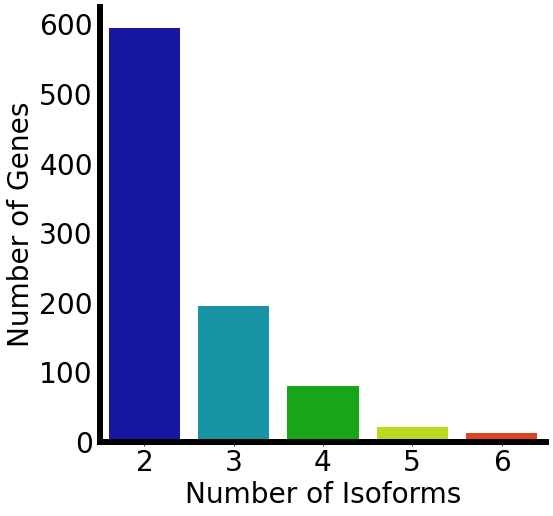

In [87]:
sns.countplot(x="Number of Isoforms", data=medically_relevant_counts_multiple_iso, palette="nipy_spectral")
sns.despine()
plt.ylabel("Number of Genes")
plt.savefig('../../figures/uky_CS_summit/multiple_isoforms_in-person.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [76]:
#chm13_novel_genes.drop(columns=["is_novel_transcript", "is_novel_gene"], inplace=True)

grch38_novel_genes["Label"] = "New Genes"

In [77]:
all_novel_genes = grch38_novel_genes.copy()

In [78]:
all_novel_genes = all_novel_genes[(all_novel_genes["total_CPM"]>1)]

In [75]:
all_novel_genes.shape

(79, 10)

In [94]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 1.6,8
rcParams.update({'font.size': 28})
rcParams['axes.linewidth'] = 6

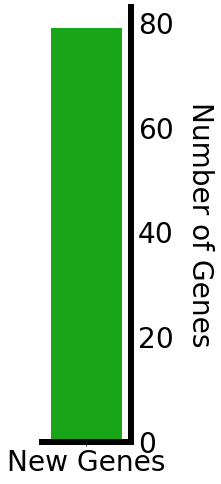

In [95]:
fig, ax1 = plt.subplots()
ax1.yaxis.set_ticks_position("right")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

sns.countplot(x="Label", data=all_novel_genes, palette="nipy_spectral", ax=ax1)

plt.ylabel("Number of Genes", rotation=270, labelpad=40)
plt.xlabel("", labelpad=4)
sns.despine(right=False, left=True, top=True, bottom=False)

plt.savefig('../../figures/uky_CS_summit/novel_genes_in-person.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()